<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ipdb
!pip install einops

torch.Size([100, 1, 28, 28]) torch.Size([100])


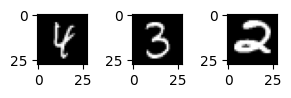

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from einops.layers.torch import Reduce
import ipdb

device = "cuda" if torch.cuda.is_available() else "cpu"

trans = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="dataset/", transform=trans, download=True, train=True) # 6W张图片 1,28,28
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(image.shape, label.shape) # 100,1,28,28; 100

fig, axs = plt.subplots(1, 3, figsize=(3, 1))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(image[i][0].cpu(), cmap='gray')
plt.tight_layout()
plt.show()

In [4]:
# https://www.jianshu.com/p/06a40338dc7c
class PatchEmbedding(nn.Module):
  def __init__(self, patch_size: int = 4, emb_size: int = 40, img_size: int = 28):
      self.patch_size = patch_size
      super().__init__()
      self.conv = nn.Conv2d(1, emb_size, kernel_size=patch_size, stride=patch_size)
      self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) # 1,1,40
      self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size)) # 50,40

  def forward(self, x):
      b, _, _, _ = x.shape # 100,1,28,28
      x = self.conv(x) # => 100,40,7,7
      x = rearrange(x, 'b e (h) (w) -> b (h w) e') # => 100,49,40
      cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
      x = torch.cat([cls_tokens, x], dim=1) # => 100,50,40
      x += self.positions
      return x # 100,50,40

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size: int = 40, num_heads: int = 4, dropout: float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.qkv = nn.Linear(emb_size, emb_size * 3)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x):
    x = self.qkv(x) # 100,50,40 => 100,50,120
    qkv = rearrange(x, "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3) # => 3,100,4,50,10
    queries, keys, values = qkv[0], qkv[1], qkv[2] # => 100,4,50,10
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # => 100,4,50,50
    scaling = self.emb_size ** (1/2)
    att = nn.functional.softmax(energy, dim=-1) / scaling
    att = self.att_drop(att)

    out = torch.einsum('bhal, bhlv -> bhav ', att, values) # => 100,4,50,10
    out = rearrange(out, "b h n d -> b n (h d)") # => 100,50,40
    out = self.projection(out) # => 100,50,40
    return out

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x):
    res = x
    x = self.fn(x)
    x += res
    return x

class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
    super().__init__(
      nn.Linear(emb_size, expansion * emb_size),
      nn.GELU(),
      nn.Dropout(drop_p),
      nn.Linear(expansion * emb_size, emb_size),
    )

class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,emb_size: int = 40,drop_p: float = 0.):
    super().__init__(
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        MultiHeadAttention(),
        nn.Dropout(drop_p)
      )),
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        FeedForwardBlock(emb_size),
        nn.Dropout(drop_p)
      )
      ))

class TransformerEncoder(nn.Sequential):
  def __init__(self, depth: int = 4):
    super().__init__(*[TransformerEncoderBlock() for _ in range(depth)])

class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size: int = 40, n_classes: int = 10):
    super().__init__(
      Reduce('b n e -> b e', reduction='mean'), # 100,50,40 => 100,40
      nn.LayerNorm(emb_size),
      nn.Linear(emb_size, n_classes)) # 100,40 => 100,10

class ViT(nn.Sequential):
  def __init__(self):
    super().__init__(
      PatchEmbedding(),
      TransformerEncoder(),
      ClassificationHead()
    )

In [6]:
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

total_loss = []
errorTotal = 0
for epoch in range(1,3):
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())
    maxV,maxIdx = outputs.max(dim=1)
    errorNum = torch.sum(torch.ne(maxIdx, label)).item()
    errorTotal += errorNum

    if(batch_idx % 100 == 99):
      print("epoch:{} batch:{} loss:{:.2f} mean:{:.2f} error:{}/{} {:.2f}%".format(epoch, batch_idx, loss, np.mean(total_loss), errorTotal, (batch_idx+1) * epoch * 100, errorTotal / (batch_idx+1) / epoch))

epoch:1 batch:99 loss:2.30 mean:2.33 error:9120/10000 91.20%
epoch:1 batch:199 loss:2.26 mean:2.30 error:17548/20000 87.74%
epoch:1 batch:299 loss:1.75 mean:2.24 error:24848/30000 82.83%
epoch:1 batch:399 loss:1.38 mean:2.07 error:29616/40000 74.04%
epoch:1 batch:499 loss:1.17 mean:1.89 error:32808/50000 65.62%
epoch:1 batch:599 loss:0.89 mean:1.74 error:35343/60000 58.91%
epoch:2 batch:99 loss:0.80 mean:1.62 error:37566/20000 187.83%
epoch:2 batch:199 loss:0.69 mean:1.52 error:39525/40000 98.81%
epoch:2 batch:299 loss:0.67 mean:1.43 error:41268/60000 68.78%
epoch:2 batch:399 loss:0.50 mean:1.35 error:42848/80000 53.56%
epoch:2 batch:499 loss:0.62 mean:1.28 error:44392/100000 44.39%
epoch:2 batch:599 loss:0.48 mean:1.23 error:45794/120000 38.16%


In [12]:
trans_test = transforms.Compose([transforms.ToTensor()])
dataset_test = datasets.MNIST(root="dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
criterion_test = nn.CrossEntropyLoss()

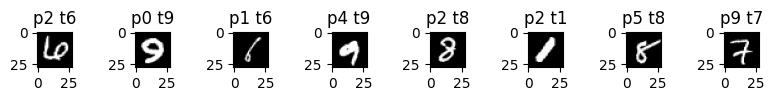

batch:9 loss:0.52 mean:0.53 error:136/1000 13.60%


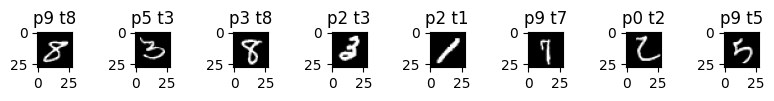

batch:19 loss:0.55 mean:0.53 error:260/2000 13.00%


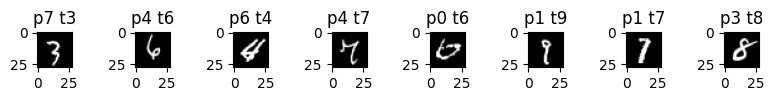

batch:29 loss:0.55 mean:0.53 error:384/3000 12.80%


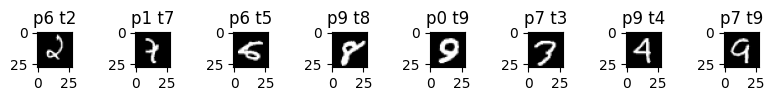

batch:39 loss:0.52 mean:0.54 error:530/4000 13.25%


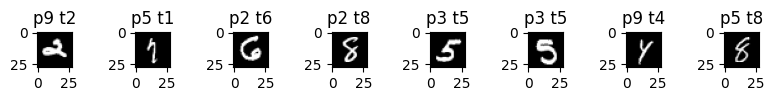

batch:49 loss:0.47 mean:0.53 error:659/5000 13.18%


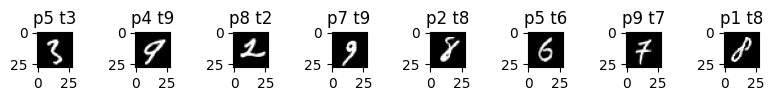

batch:59 loss:0.57 mean:0.54 error:780/6000 13.00%


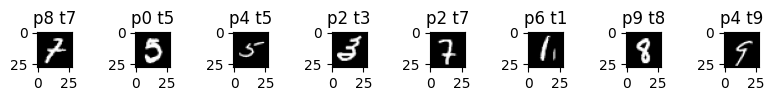

batch:69 loss:0.63 mean:0.54 error:921/7000 13.16%


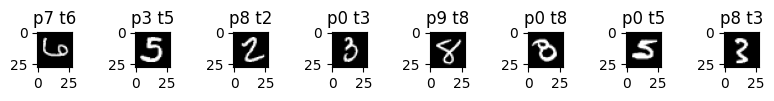

batch:79 loss:0.48 mean:0.54 error:1043/8000 13.04%


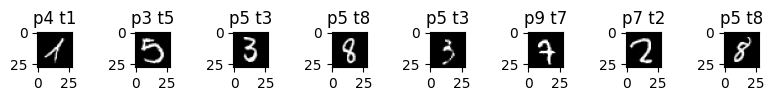

batch:89 loss:0.57 mean:0.54 error:1189/9000 13.21%


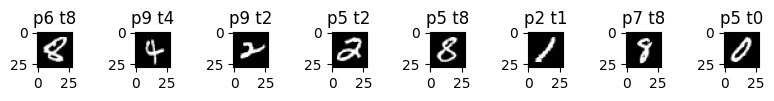

batch:99 loss:0.58 mean:0.54 error:1328/10000 13.28%


In [13]:
total_loss = []
errorTotal = 0
for batch_idx, (img, label) in enumerate(loader_test): # 1W张图片, 100批, 100,1,28,28
  img = img.to(device)
  label = label.to(device)

  output = model(img)
  loss = criterion_test(output, label)
  total_loss.append(loss.item())

  maxV,maxIdx = output.max(dim=1)
  errorNum = torch.sum(torch.ne(maxIdx, label)).item()
  errorTotal += errorNum

  noMatchIdx = torch.nonzero(torch.ne(maxIdx, label)).view(-1)

  if(batch_idx % 10 == 9):
    if errorNum > 8:
      errorNum = 8
    fig, axs = plt.subplots(1, errorNum, figsize=(errorNum, 1))
    for i, ax in enumerate(axs.flatten()):
      idx = noMatchIdx[i]
      ax.imshow(img[idx][0].cpu(), cmap='gray')
      ax.set_title('p{} t{}'.format(maxIdx[idx], label[idx]))
    plt.tight_layout()
    plt.show()
    print("batch:{} loss:{:.2f} mean:{:.2f} error:{}/{} {:.2f}%".format(batch_idx, loss, np.mean(total_loss), errorTotal, (batch_idx+1) * 100, errorTotal / (batch_idx+1)))